In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
pd.options.mode.chained_assignment = None
import iris
import iris.quickplot as qplt
import iris.plot as iplt
from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import Utils.iris_utils
import Utils.Gridding
from Utils.nc_processing import *
from Utils.analysis import * 
#from Utils.plotting import *
import esmvalcore.preprocessor
import xesmf as xe
import warnings
%matplotlib inline
import seaborn as sns
import scipy
#sns.set()

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    

def make_df(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return df

def get_baseline(df, t_bnds=[1850, 1900], monthly=False, multi_ens=False):
    df_hist = df[df['Experiment']=='historical']
    df_hist = df_hist[df_hist['year'] > t_bnds[0]][df_hist['year'] < t_bnds[1]]
    df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])
    if monthly:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds', 'Month']).mean().reset_index().rename(columns=baseline_name_changes)
    else:
        if multi_ens:
            df_hist = df_hist.groupby(['Model', 'Ensemble_member', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
        else:
            df_hist = df_hist.groupby(['Model', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
    df_hist = df_hist.drop(columns=['year'])
    return df_hist

def wmean(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()

def preprocess_hadcrut_z(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['Year'].between(preind_period[0], preind_period[1])]
    offset = df_pre_ind['Anomaly (deg C)'].mean()
    df_out = df[['Year', 'Anomaly (deg C)']]
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'] - offset
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'].rolling(window, center=True).mean()
    return df_out

def preprocess_hadcrut(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    #df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['year'].between(preind_period[0], preind_period[1])]
    offset_w = df_pre_ind['world_tas'].mean()
    offset_na = df_pre_ind['no_arctic_tas'].mean()
    df_out = df.copy()
    df_out['world_tas'] = df_out['world_tas'] - offset_w
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'] - offset_na
    df_out['world_tas'] = df_out['world_tas'].rolling(window, center=True).mean()
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'].rolling(window, center=True).mean()
    return df_out

/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/iris/experimental/regrid.py:55: IrisDeprecation: The 'iris.experimental.regrid' package is deprecated since version 3.2, and will be removed in a future release.  The PointInCell class has now moved into iris.analysis.  All its other content will be withdrawn.  If you still use any of this, please contact the Iris Developers to discuss how to replace it or to retain it (reverse the deprecation).
  warn_deprecated(wmsg)


In [2]:
### set up and read in temp data

## models
baseline_name_changes = {'no_arctic_tas':'no_arctic_base_tas',
                         'world_tas':'world_base_tas',
                        }
window=15
temp_thresh = 1.5
#temp_thresh = 2

in_folder_tas = 'int_outputs/temperature_v2/'
#exp='ssp370'
exp='ssp245'
#exp='ssp126'
tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]
#tas_df.set_index('year',inplace=True)
print(tas_df['Model'].unique())

## observations
#Hadcrut_file = 'Inputs/HadCRUT5/Downloaded_29_12_22/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv'
Hadcrut_file = 'int_outputs/temperature_hadcrut/hadcrut5_tas.csv'
Hadcrut_df = preprocess_hadcrut(pd.read_csv(Hadcrut_file), window=window)



['TaiESM1' 'AWI-CM-1-1-MR' 'MCM-UA-1-0' 'CIESM' 'SAM0-UNICON' 'NESM3'
 'GFDL-ESM4' 'GFDL-CM4' 'UKESM1-0-LL' 'KACE-1-0-G' 'NorESM2-MM'
 'NorESM2-LM' 'NorCPM1' 'CESM2-WACCM-FV2' 'CESM2-WACCM' 'CESM2-FV2'
 'CESM2' 'GISS-E2-2-H' 'GISS-E2-1-H' 'GISS-E2-1-G-CC' 'GISS-E2-1-G'
 'MRI-ESM2-0' 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR' 'UKESM1-1-LL'
 'HadGEM3-GC31-MM' 'HadGEM3-GC31-LL' 'MIROC6' 'MIROC-ES2L' 'MIROC-ES2H'
 'KIOST-ESM' 'IPSL-CM6A-LR-INCA' 'IPSL-CM6A-LR' 'IPSL-CM5A2-INCA'
 'INM-CM5-0' 'INM-CM4-8' 'MPI-ESM-1-2-HAM' 'FIO-ESM-2-0'
 'EC-Earth3-Veg-LR' 'BCC-CSM2-MR' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'FGOALS-f3-L'
 'FGOALS-g3' 'IITM-ESM' 'CanESM5' 'CanESM5-CanOE' 'CMCC-CM2-SR5'
 'CMCC-ESM2' 'CNRM-CM6-1' 'CNRM-CM6-1-HR' 'CNRM-ESM2-1' 'ACCESS-ESM1-5'
 'ACCESS-CM2' 'E3SM-1-1' 'EC-Earth3' 'EC-Earth3-CC' 'EC-Earth3-Veg']


In [3]:
### initial processing, add baseline temp to each model, 
### only keep those models with a historic scenario available

tas_df = tas_df.groupby(['year', 'Experiment', 'Model']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900])
tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()
models

/tmp/ipykernel_570/3777482543.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_hist = df_hist[df_hist['year'] > t_bnds[0]][df_hist['year'] < t_bnds[1]]


array(['AWI-CM-1-1-MR', 'CESM2', 'CESM2-WACCM', 'CIESM',
       'EC-Earth3-Veg-LR', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4',
       'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MCM-UA-1-0',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1',
       'UKESM1-0-LL'], dtype=object)

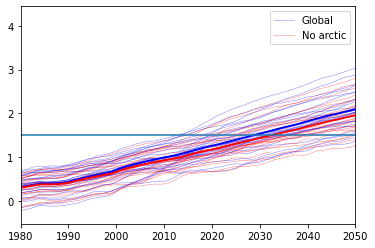

In [4]:
### initial basic plot, no correction to force realistic present temps

for model in models:
    df = tas_df[tas_df['Model']==model]
    plt.plot(df['year'], df['world_tas_anom'].rolling(window, center=True).mean(), c='b', alpha=0.5, linewidth=0.5, label='Global')
    plt.plot(df['year'], df['no_arctic_tas_anom'].rolling(window, center=True).mean(), c='r', alpha=0.5, linewidth=0.5, label='No arctic')

df = tas_df.groupby(['year']).mean().reset_index() 
plt.plot(df['year'], df['world_tas_anom'].rolling(window, center=True).mean(), c='b', alpha=1, linewidth=2, label='Global')
plt.plot(df['year'], df['no_arctic_tas_anom'].rolling(window, center=True).mean(), c='r', alpha=1, linewidth=2, label='No arctic')

legend_without_duplicate_labels(plt.gca())
plt.xlim(1980,2050)
plt.axhline(1.5)
plt.savefig('Figures/tas_anom_global_and_no_arctic.png', dpi=300)


In [5]:


#df= tas_df[tas_df['Experiment'] == exp]
df = tas_df.drop(columns=['Experiment'])
models = df['Model'].unique()
Model = []
No_arctic = []
World = []

for m in models:
    m_df = df[df['Model']==m]
    no_arctic_crossing_year = np.interp(temp_thresh, m_df['no_arctic_tas_anom'].rolling(window, center=True).mean(), m_df['year'])
    world_crossing_year = np.interp(temp_thresh, m_df['world_tas_anom'].rolling(window, center=True).mean(), m_df['year'])
    Model.append(m)
    No_arctic.append(np.round(no_arctic_crossing_year,3))
    World.append(np.round(world_crossing_year,3))

out_df = pd.DataFrame({'Model':Model,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']
print('mean gap for crossing {}C: '.format(temp_thresh) + str(np.round(out_df['gap'].mean(), 2)))
#out_df.to_csv('Outputs/crossing_years.csv')
out_df

mean gap for crossing 1.5C: 3.95


Model  No_arctic_crossing_year  World_crossing_year    gap
0      AWI-CM-1-1-MR                 2023.549             2020.034  3.515
1              CESM2                 2035.628             2032.100  3.528
2        CESM2-WACCM                 2029.701             2026.925  2.776
3              CIESM                 2014.088             2012.670  1.418
4   EC-Earth3-Veg-LR                 2035.252             2026.089  9.163
5        FIO-ESM-2-0                 2020.640             2017.554  3.086
6           GFDL-CM4                 2035.954             2030.516  5.438
7          GFDL-ESM4                 2049.847             2048.153  1.694
8        GISS-E2-1-G                 2059.211             2052.517  6.694
9    HadGEM3-GC31-LL                 2024.541             2021.914  2.627
10         INM-CM4-8                 2039.362             2035.937  3.425
11         INM-CM5-0                 2037.035             2032.582  4.453
12      IPSL-CM6A-LR                 2018.225             2014.541  3.684
13        KACE-1-0-G                 2015.899             2013.650  2.249
14         KIOST-ESM                 2025.474             2022.231  3.243
15        MCM-UA-1-0                 2026.227             2025.259  0.968
16        MIROC-ES2L                 2044.375             2039.021  5.354
17            MIROC6                      NaN                  NaN    NaN
18     MPI-ESM1-2-HR                 2039.469             2033.954  5.515
19     MPI-ESM1-2-LR                 2041.621             2034.781  6.840
20        MRI-ESM2-0                 2037.731             2031.833  5.898
21             NESM3                 2036.088             2031.384  4.704
22        NorESM2-LM                 2064.561             2059.680  4.881
23        NorESM2-MM                 2050.029             2046.624  3.405
24           TaiESM1                 2033.398             2030.668  2.730
25       UKESM1-0-LL                 2020.783             2019.397  1.386

In [6]:
df.columns

Index(['year', 'Model', 'no_arctic_tas', 'world_tas', 'base_t_bnds',
       'no_arctic_base_tas', 'world_base_tas', 'no_arctic_tas_anom',
       'world_tas_anom'],
      dtype='object')

observation year: 2015
HadCRUT temp in obs_year:1.0617714413162076
HadCRUT temp without AA in obs_year:0.981350423321228
AA contrib:0.08042101799497958
AA contrib (%)0.07574230655072714


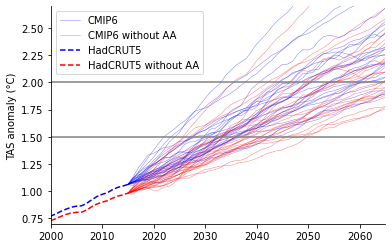

In [7]:
""" repeat, this time scaling temps to current observed warming """

global_warming_obs = float(Hadcrut_df.dropna().tail(1)['world_tas'])
no_arctic_warming_obs = float(Hadcrut_df.dropna().tail(1)['no_arctic_tas'])

obs_year = int(Hadcrut_df.dropna().tail(1)['year'])

Model = []
No_arctic = []
World = []
df = tas_df
M_df = pd.DataFrame(columns=df.columns)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for m in models:
        m_df = df[df['Model']==m]
        m_df['rolling_world_anom'] = m_df['world_tas_anom'].rolling(window, center=True).mean()
        m_df['rolling_no_arctic_anom'] = m_df['no_arctic_tas_anom'].rolling(window, center=True).mean()
        
        ratio_w = (m_df[m_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
        ratio_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]
        
        m_df['adjusted_world_tas_anom']= (m_df['world_tas_anom']/ratio_w).rolling(window, center=True).mean()
        m_df['adjusted_no_arctic_tas_anom']= (m_df['no_arctic_tas_anom']/ratio_na).rolling(window, center=True).mean()
        
        m_df_plot = m_df[m_df['year'] >= obs_year]
        
        plt.plot(m_df_plot['year'], m_df_plot['adjusted_world_tas_anom'],
                 c='b', alpha=0.5, linewidth=0.5, label='CMIP6')
        plt.plot(m_df_plot['year'], m_df_plot['adjusted_no_arctic_tas_anom'], 
                 c='r', alpha=0.5, linewidth=0.5, label='CMIP6 without AA')

        M_df = M_df.append(m_df, ignore_index = True)
        #also calc crossings again
        no_arctic_crossing_year = np.interp(temp_thresh, m_df['adjusted_no_arctic_tas_anom'], m_df['year'])
        world_crossing_year = np.interp(temp_thresh, m_df['adjusted_world_tas_anom'], m_df['year'])
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))

out_df = pd.DataFrame({'Model':Model,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']

#mm_mean_df = out_df.groupby()

## add observations:
plt.plot(Hadcrut_df['year'], Hadcrut_df['world_tas'], c='blue', 
         linestyle='--', label='HadCRUT5')
plt.plot(Hadcrut_df['year'], Hadcrut_df['no_arctic_tas'], c='red', 
         linestyle='--', label='HadCRUT5 without AA')

legend_without_duplicate_labels(plt.gca())
plt.xlim(2000,2065)
plt.ylim(0.7, 2.7)
plt.axhline(2, color='gray')
plt.axhline(1.5, color='gray')
plt.ylabel('TAS anomaly (°C)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('Figures/tas_projections.png', dpi=300)

print('observation year: ' + str(obs_year))
print('HadCRUT temp in obs_year:' + str(global_warming_obs))
print('HadCRUT temp without AA in obs_year:' + str(no_arctic_warming_obs))
print('AA contrib:' + str((global_warming_obs-no_arctic_warming_obs)))
print('AA contrib (%)' + str((global_warming_obs-no_arctic_warming_obs)/global_warming_obs))

In [8]:
cols_to_keep_m_df = ['year', 'Experiment', 'Model', 'adjusted_world_tas_anom', 'adjusted_no_arctic_tas_anom']
M_df = M_df[cols_to_keep_m_df]

M_df.to_csv('Outputs/master_df_temp_projections_{r}yr_rolling_{scenario}.csv'.format(r=window, scenario=exp))
Hadcrut_df.to_csv('Outputs/Processed_Hadcrut_{r}yr_rolling.csv'.format(r=window))

In [9]:
mean = str(np.round(out_df['gap'].mean(), 2))
standard_error = str(np.round(out_df['gap'].sem(), 2))
print('mean gap for crossing {}C: '.format(temp_thresh)+mean+' +- '+standard_error+' years')
out_df.to_csv('Outputs/crossing_years_adjusted_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
out_df

mean gap for crossing 1.5C: 5.33 +- 0.5 years


Model  No_arctic_crossing_year  World_crossing_year     gap
0      AWI-CM-1-1-MR                 2042.652             2036.983   5.669
1              CESM2                 2033.439             2029.996   3.443
2        CESM2-WACCM                 2037.981             2033.010   4.971
3              CIESM                 2041.739             2033.025   8.714
4   EC-Earth3-Veg-LR                 2035.232             2028.344   6.888
5        FIO-ESM-2-0                 2038.996             2032.843   6.153
6           GFDL-CM4                 2031.599             2027.529   4.070
7          GFDL-ESM4                 2049.736             2043.613   6.123
8        GISS-E2-1-G                 2033.294             2029.676   3.618
9    HadGEM3-GC31-LL                 2026.164             2022.024   4.140
10         INM-CM4-8                 2038.518             2030.800   7.718
11         INM-CM5-0                 2032.649             2027.319   5.330
12      IPSL-CM6A-LR                 2040.719             2036.168   4.551
13        KACE-1-0-G                 2032.486             2027.630   4.856
14         KIOST-ESM                 2048.423             2036.127  12.296
15        MCM-UA-1-0                 2045.478             2035.088  10.390
16        MIROC-ES2L                 2034.668             2030.061   4.607
17            MIROC6                      NaN             2030.831     NaN
18     MPI-ESM1-2-HR                 2046.202             2042.031   4.171
19     MPI-ESM1-2-LR                 2042.429             2035.814   6.615
20        MRI-ESM2-0                 2037.494             2032.934   4.560
21             NESM3                 2040.779             2035.941   4.838
22        NorESM2-LM                 2033.265             2032.103   1.162
23        NorESM2-MM                 2036.893             2033.645   3.248
24           TaiESM1                 2025.748             2024.134   1.614
25       UKESM1-0-LL                 2027.000             2023.385   3.615

In [10]:
len(out_df)

26

In [11]:
### now generate box plot by model (vertical), with multiple ensemble members for error bars

in_folder_tas = 'int_outputs/temperature_multi_ens/'

tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]

tas_df = tas_df.groupby(['year', 'Experiment', 'Model', 'Ensemble_member']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900], multi_ens=True)

tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model', 'Ensemble_member'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()

#tas_df = tas_df[tas_df['Experiment'] != 'historical']
#tas_df = tas_df.drop(columns=['Experiment'])

#also calc crossings
Model = []
Ensemble_member = []
No_arctic = []
World = []
for m in models:
    m_df = tas_df[tas_df['Model']==m]
    ens_mems = m_df[m_df['Experiment']=='ssp245']['Ensemble_member'].unique()
    #print(m)
    for e in ens_mems:
        #print(e)
    
        me_df = m_df[m_df['Ensemble_member']==e]
        me_df.sort_values(by='year', axis=0)

        me_df['rolling_world_anom'] = me_df['world_tas_anom'].rolling(window, center=True).mean()
        me_df['rolling_no_arctic_anom'] = me_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        try:
            ratio_w = (me_df[me_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
            ratio_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]
        except:
            print('error on: ' + m + e)
            
        me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom']/ratio_w)
        me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom']/ratio_na)
        
        no_arctic_crossing_year = np.interp(temp_thresh, me_df['adjusted_no_arctic_tas_anom'], me_df['year'])
        world_crossing_year = np.interp(temp_thresh, me_df['adjusted_world_tas_anom'], me_df['year'])
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))
        Ensemble_member.append(e)
            

out_df_ME = pd.DataFrame({'Model':Model,
                          'Ensemble_member':Ensemble_member,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df_ME['gap'] = out_df_ME['No_arctic_crossing_year'] - out_df_ME['World_crossing_year']

out_df_ME_all = out_df_ME.copy()
out_df_ME_all.to_csv('Outputs/Crossing_years_multi_ensemble_mems_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
## keep only models with more than x ensemble members:
ens_members_needed = 3
models_to_keep = []
for m in models:
    n = len(out_df_ME[out_df_ME['Model']==m])
    if n >= ens_members_needed:
        models_to_keep.append(m)

out_df_ME = out_df_ME[out_df_ME['Model'].isin(models_to_keep)]

out_df_ME.to_csv('Outputs/Crossing_years_multi_ensemble_mems_for_box_plot_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))



/tmp/ipykernel_570/3777482543.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_hist = df_hist[df_hist['year'] > t_bnds[0]][df_hist['year'] < t_bnds[1]]


error on: E3SM-1-1r1i1p1f1


In [12]:
out_df_ME_all

Model Ensemble_member  No_arctic_crossing_year  \
0       ACCESS-CM2        r1i1p1f1                 2027.388   
1       ACCESS-CM2        r2i1p1f1                 2028.935   
2    ACCESS-ESM1-5        r1i1p1f1                 2029.352   
3    ACCESS-ESM1-5        r2i1p1f1                 2034.179   
4    ACCESS-ESM1-5        r3i1p1f1                 2027.405   
..             ...             ...                      ...   
177    UKESM1-0-LL        r2i1p1f2                 2024.806   
178    UKESM1-0-LL        r3i1p1f2                 2029.113   
179    UKESM1-0-LL        r4i1p1f2                 2025.200   
180    UKESM1-0-LL        r8i1p1f2                 2028.684   
181    UKESM1-0-LL        r9i1p1f2                 2024.786   

     World_crossing_year    gap  
0               2024.286  3.102  
1               2025.372  3.563  
2               2027.189  2.163  
3               2031.482  2.697  
4               2024.039  3.366  
..                   ...    ...  
177             2021.892  2.914  
178             2024.995  4.118  
179             2022.148  3.052  
180             2025.343  3.341  
181             2022.083  2.703  

[182 rows x 5 columns]

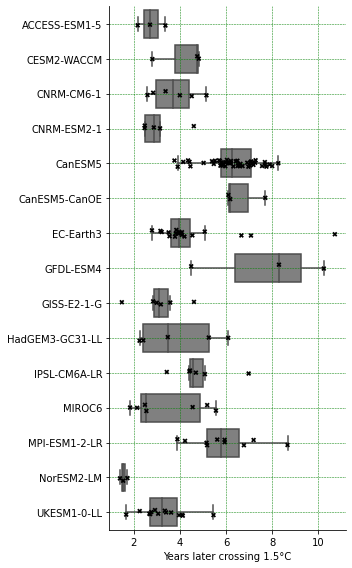

In [13]:
## plot
sns.boxplot(data=out_df_ME, x='gap', y='Model', color='gray', showfliers = False)
sns.stripplot(data=out_df_ME, x='gap', y='Model', color='black', marker='X')
plt.ylabel('')
plt.xlabel('Years later crossing {}°C'.format(temp_thresh))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

fig = plt.gcf()
fig.set_size_inches(5, 8)
plt.tight_layout()
plt.savefig('Figures/crossing_years.png', dpi=300)

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(out_df_ME)


               Model Ensemble_member  No_arctic_crossing_year  \
2      ACCESS-ESM1-5        r1i1p1f1                 2029.352   
3      ACCESS-ESM1-5        r2i1p1f1                 2034.179   
4      ACCESS-ESM1-5        r3i1p1f1                 2027.405   
9        CESM2-WACCM        r1i1p1f1                 2035.818   
10       CESM2-WACCM        r2i1p1f1                 2040.749   
11       CESM2-WACCM        r3i1p1f1                 2037.507   
15        CNRM-CM6-1       r10i1p1f2                      NaN   
16        CNRM-CM6-1        r1i1p1f2                 2034.627   
17        CNRM-CM6-1        r2i1p1f2                 2030.171   
18        CNRM-CM6-1        r3i1p1f2                 2034.650   
19        CNRM-CM6-1        r4i1p1f2                 2029.769   
20        CNRM-CM6-1        r5i1p1f2                 2033.364   
21        CNRM-CM6-1        r6i1p1f2                 2032.558   
22        CNRM-CM6-1        r7i1p1f2                      NaN   
23        CNRM-CM6-1     